<a href="https://colab.research.google.com/github/evocellnet/sysbio_teaching/blob/main/Ex10_Enrichment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enrichment Analysis

Once differentially expressed proteins are identified (see exercise 9), enrichment analysis methods can be used to explore the biological functions associated with these proteins. 

The goal of this exercise is to perform **enrichment analysis** of proteins with significant abundance changes between **Luminal A and Luminal B** using two different approaches: 
- **GO enrichment analysis** (**GOEA**): method to identify enriched Gene Ontology (GO) terms in a set of genes or proteins, compared to a background set. GO terms are standardized vocabulary terms that describe gene products in terms of their molecular function, biological process, and cellular component (http://geneontology.org/docs/ontology-documentation/). 
- Gene set enrichment analysis (**GSEA** - https://www.pnas.org/doi/abs/10.1073/pnas.0506580102): method to identify gene sets that are enriched in one biological condition compared to another using ranked gene lists. Tests whether a predefined set of genes, such as a set of genes involved in a particular biological pathway or function, is enriched at the top or bottom of the ranked list.



In [1]:
#@title Getting started { display-mode: "form" }
#@markdown Set up the environment, and download the raw data from ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) used throughout the praktikum:
#@markdown - Remove Colab `/content/sample_data/` directory to avoid confusion
!rm -rf sample_data

#@markdown - Upgrade scikit-learn, as the default Colab version does not have `DecisionBoundaryDisplay`
!pip install -U scikit-learn

#@markdown - Install the Goatools package to perform Enrichment analysis
!pip install goatools
#@markdown - Install the gseapy package to perform Gene Set Enrichment analysis
!pip install gseapy

#@markdown - Download an .obo file of the most current GO
! wget http://current.geneontology.org/ontology/go-basic.obo

#@markdown - Download ([Krug et al., 2020](https://doi.org/10.1016/j.cell.2020.10.036)) supplementary materials & store them under `/content/` as `Krug2020_S1.xlsx` etc
!wget -nv -O Krug2020_S1.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc1.xlsx
!wget -nv -O Krug2020_S2.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc2.xlsx
!wget -nv -O Krug2020_S3.xlsx https://ars.els-cdn.com/content/image/1-s2.0-S0092867420314008-mmc3.xlsx

#@markdown - Import modules from numpy, pandas, seaborn, sklearn
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import sklearn.inspection, sklearn.metrics, sklearn.neighbors, sklearn.svm, sklearn.pipeline, sklearn.preprocessing

#@markdown - Fix `RANDOM_SEED` for (partial) reproducibility
RANDOM_SEED = 4 # https://xkcd.com/221

#@markdown - Clone the "sysbio_teaching" GitHub repository into your Colab environment
!git clone https://github.com/evocellnet/sysbio_teaching.git

def plot_question_mark(ax):
  ax.text(x=.5, y=.5, s='?', color='red', fontsize=64,
          horizontalalignment='center',
          verticalalignment='center',
          transform=ax.transAxes)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=07f38841a9419785b6bc1b5ee77290df8325dddf2a7aaa7b6fad66161b25bb9b
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00
--2023-04-27 20:08:33--  http://current.geneontology.org/ontology/go-basic.obo
Resolving current.geneontology.org (current.geneontolog

## Import the required libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Load list of differentially expressed proteins between Luminal A and Luminal B samples, which was produced in Exercise 9

In [3]:
df = pd.read_csv('/content/sysbio_teaching/Ex10/out_annotated.txt', low_memory = False, sep = "\t")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6273 entries, 0 to 6272
Columns: 141 entries, id to Gene_id
dtypes: bool(1), float64(128), int64(4), object(8)
memory usage: 6.7+ MB


# Approach 1: **GO enrichment analysis**

In [9]:
#@title Load GO Ontologies and their associated genes { display-mode: "form" }

import sys
import os

module_path = os.path.abspath("/content/sysbio_teaching/Ex10/")
if module_path not in sys.path:
    sys.path.append(module_path)

#@markdown - Download Ontologies (Molecular Function - MF, Biological Process - BP, and Cellular Component - CC)
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

#@markdown - Download Gene-GO associations (annotation of genes to GO terms)
from goatools.base import download_ncbi_associations
gene2go = download_ncbi_associations()
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt


from __future__ import print_function
from goatools.anno.genetogo_reader import Gene2GoReader

#@markdown - Store Gene-GO associations for the different GO categories (BP, MF, CC)
objanno = Gene2GoReader(gene2go, taxids=[9606])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated human genes".format(NS=nspc, N=len(id2gos)))


  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-04-01) 46,575 Terms
  EXISTS: gene2go
HMS:0:00:06.892560 342,553 annotations, 20,749 genes, 18,982 GOs, 1 taxids READ: gene2go 
MF 18,259 annotated human genes
CC 19,755 annotated human genes
BP 18,649 annotated human genes



### Load Background gene set (reference)

#### The background in this exercise is represented by all human proteins 

In [10]:
from genes_ncbi_9606_proteincoding import GENEID2NT as GeneID2nt
print(len(GeneID2nt))

19616


### Define parameters for enrichment 

In [11]:
## Initialize a GOEA object
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        GeneID2nt.keys(), # List of human protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method

#Important note: by default, find_enrichment.py propagates counts to all the parents of a GO term. 
#(defined in terms of is_a tags, only)
#As a result, users may find terms in the output that are not present in their association file. 
#propagate_counts = False to disable this behavior.


Load BP Ontology Enrichment Analysis ...
 87% 16,971 of 19,616 population items found in association

Load CC Ontology Enrichment Analysis ...
 92% 18,084 of 19,616 population items found in association

Load MF Ontology Enrichment Analysis ...
 89% 17,556 of 19,616 population items found in association


**!!! Question !!!**

1- How does the result of GO enrichment analysis change if you use Bonferroni correction? Do you expect more or less significantly changing terms?

-> set (methods = ['bonferroni'])

### Select significant changing proteins between LumA and LumB (from ex 9) setting fold change and q-value cutoffs

In [12]:
fc_cutoff = 1
qvalue_cutoff = 0.05

df = df[(df.adj_p < qvalue_cutoff) & (abs(df.log2fc) > fc_cutoff)]

In [13]:
df = df[df['Gene_id'].notnull()] # Filter rows with non-null values in 'Gene_id' column
df['Gene_id'] = df['Gene_id'].astype(int) # Convert the 'Gene_id' column to integers
geneid2symbol = dict(zip(df['Gene_id'], df['Uniprot_id']))
geneids_study = geneid2symbol.keys()

In [14]:
len(geneids_study) #Number of differentially abundant proteins between LumA and LumB

494

In [15]:
# 'p_' means "pvalue". 'fdr_bh' is the multipletest method we are currently using.
geneids_study = geneid2symbol.keys()
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]



Runing BP Ontology Analysis: current study set of 494 IDs.
 95%    471 of    494 study items found in association
100%    494 of    494 study items found in population(19616)
Calculating 12,434 uncorrected p-values using fisher_scipy_stats
  12,434 terms are associated with 16,971 of 19,616 population items
   2,281 terms are associated with    471 of    494 study items
  METHOD fdr_bh:
      67 GO terms found significant (< 0.05=alpha) ( 65 enriched +   2 purified): statsmodels fdr_bh
     252 study items associated with significant GO IDs (enriched)
       9 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 494 IDs.
 98%    486 of    494 study items found in association
100%    494 of    494 study items found in population(19616)
Calculating 1,779 uncorrected p-values using fisher_scipy_stats
   1,779 terms are associated with 18,084 of 19,616 population items
     443 terms are associated with    486 of    494 study items
 

In [16]:
from __future__ import print_function
go_names = [r.name for r in goea_results_sig]
print(len(go_names)) # number of signficant terms

162


In [17]:
# Create a dictionary with the GO term, p-value, and name
go_dict = {'Category': [r.NS for r in goea_results_sig],
           'GO': [r.GO for r in goea_results_sig],
           'p_fdr_bh': [r.p_fdr_bh for r in goea_results_sig],
           'study_count': [r.study_count for r in goea_results_sig],
           'name': [obodag[r.GO].name for r in goea_results_sig]}

# Convert the dictionary to a pandas DataFrame
df_goea_results = pd.DataFrame(go_dict)

In [18]:
#Filter result based on the size of GO terms
df_goea_results = df_goea_results[(df_goea_results['study_count'] > 5) & (df_goea_results['study_count'] < 500)]

In [19]:
df_goea_results.head()

,Category,GO,p_fdr_bh,study_count,name
0,BP,GO:0006958,5.530047e-16,17,"complement activation, classical pathway"
1,BP,GO:0006956,1.004556e-13,14,complement activation
2,BP,GO:0006957,1.004556e-13,12,"complement activation, alternative pathway"
3,BP,GO:0010951,2.878275e-10,16,negative regulation of endopeptidase activity
4,BP,GO:0032200,1.338934e-06,10,telomere organization


In [20]:
df_goea_results.sort_values('p_fdr_bh', inplace=True, ascending=True) #order result based on adjusted p-value

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


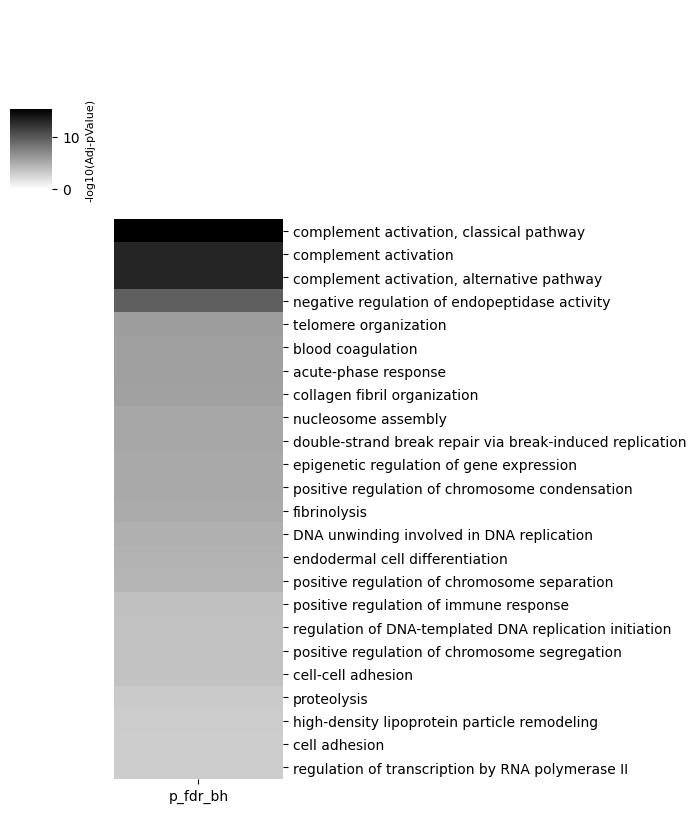

In [21]:
cg = sns.clustermap(-np.log10(df_goea_results[(df_goea_results.Category== 'BP') & (df_goea_results['p_fdr_bh'] < 0.001)]['p_fdr_bh']), yticklabels=df_goea_results[(df_goea_results.Category== 'BP')& (df_goea_results['p_fdr_bh'] < 0.001) ].name,
              linewidths=.0, cmap="binary",figsize=(3,10),
              col_cluster = False, row_cluster = False, vmin = 0,
                   cbar_kws={'label': '-log10(Adj-pValue)',"orientation": "vertical"})
cg.fig.axes[-1].yaxis.label.set_size(8) #size legend colorbar
cg.ax_cbar.set_position([-0.01, 0.7, cg.ax_row_dendrogram.get_position().width, 0.08])

**!!! Question !!!**

1- Repeat the anlalysis with more stringent cutoffs. Do you expect more or less significantly changing terms?

-> fc_cutoff = 2
qvalue_cutoff = 0.05

# Approach 2: **Gene set enrichment analysis (GSEA)**

### Rank proteins based on log2FC

In [22]:
df.sort_values('log2fc', ascending=False, inplace=True)
rnk = df[['Gene_id','log2fc']]
rnk.columns = [0,1]
rnk.reset_index(inplace=True, drop=True)
rnk[0] = rnk[0].astype(str) 

<ipython-input-22-e283fe607256>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rnk[0] = rnk[0].astype(str)


### As gene sets we use GO terms

In [23]:
# Define a dictionary to store the Gene Ontology (GO) terms and their associated genes
GO_dict = {}

# Loop through each gene and its associated biological processes (BP)
for gene, terms in ns2assoc['BP'].items():
    
    # Loop through each BP term associated with the gene
    for term in terms:
        
        # Add the gene to the list of genes associated with the BP term in the dictionary
        if term not in GO_dict:
            GO_dict[term] = []
        if gene not in GO_dict[term]:
            GO_dict[term].append(str(gene))

### Perform GSEA

In [24]:
import gseapy as gp

# run prerank
# enrichr libraries are supported by prerank module. Just provide the name
# use 4 process to acceralate the permutation speed

# note: multiprocessing may not work on windows
pre_res = gp.prerank(rnk=rnk, gene_sets=GO_dict,
                     processes=4,min_size=5,max_size=1000,
                     permutation_num=5000, # reduce number to speed up testing
                     format='png', seed=6,
                    outdir='GSEA/') # set output directory

<ipython-input-24-3307bab2685e>:8: DeprecationWarning: processes is deprecated; use threads
  pre_res = gp.prerank(rnk=rnk, gene_sets=GO_dict,
2023-04-27 20:21:02,573 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-04-27 20:21:02,584 [WARNING] Duplicated values found in preranked stats: 2.63% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Visualize results

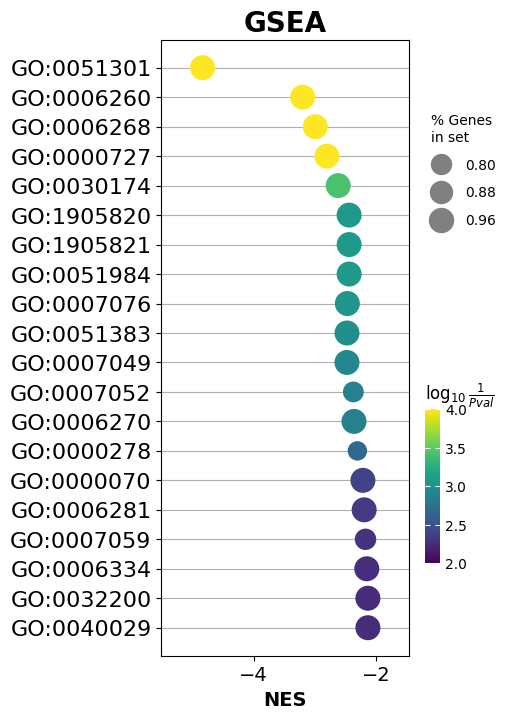

In [25]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             title='GSEA',
             cmap=plt.cm.viridis,top_term = 20,
             size=3, # adjust dot size
             figsize=(4,8), cutoff=0.25, show_ring=False)

In [26]:
len(pre_res.res2d) # Number of significanlty enriched setes

167

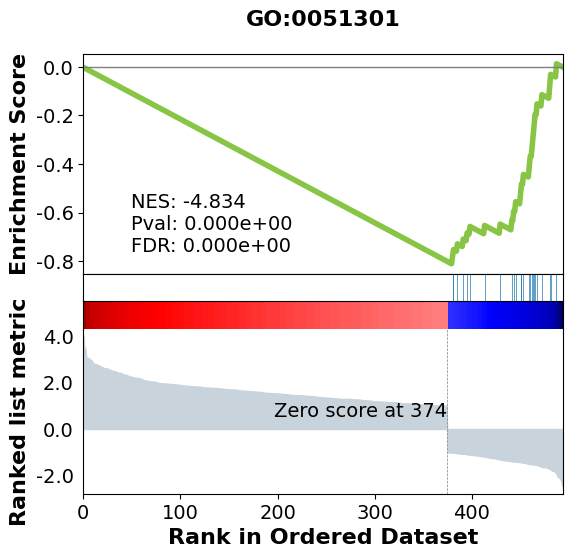

In [27]:
# Visualize GSEA plot for a specific GO term

from gseapy import gseaplot, heatmap
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(pre_res.ranking, term='GO:0051301', **pre_res.results['GO:0051301'])

In [28]:
go_table = pre_res.res2d # save result of the GSEA as table

In [29]:
# Retrieve annotation of enriched terms
GO_annot = {}
GO_annot = {GO: obodag[GO].name for GO in go_table.Term.unique() if GO not in GO_annot}
GO_annot_df = pd.DataFrame(GO_annot.items(), columns=['Term', 'Description'])
go_table_annotated = go_table.merge(GO_annot_df, on='Term', how='left').sort_index(axis=1)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


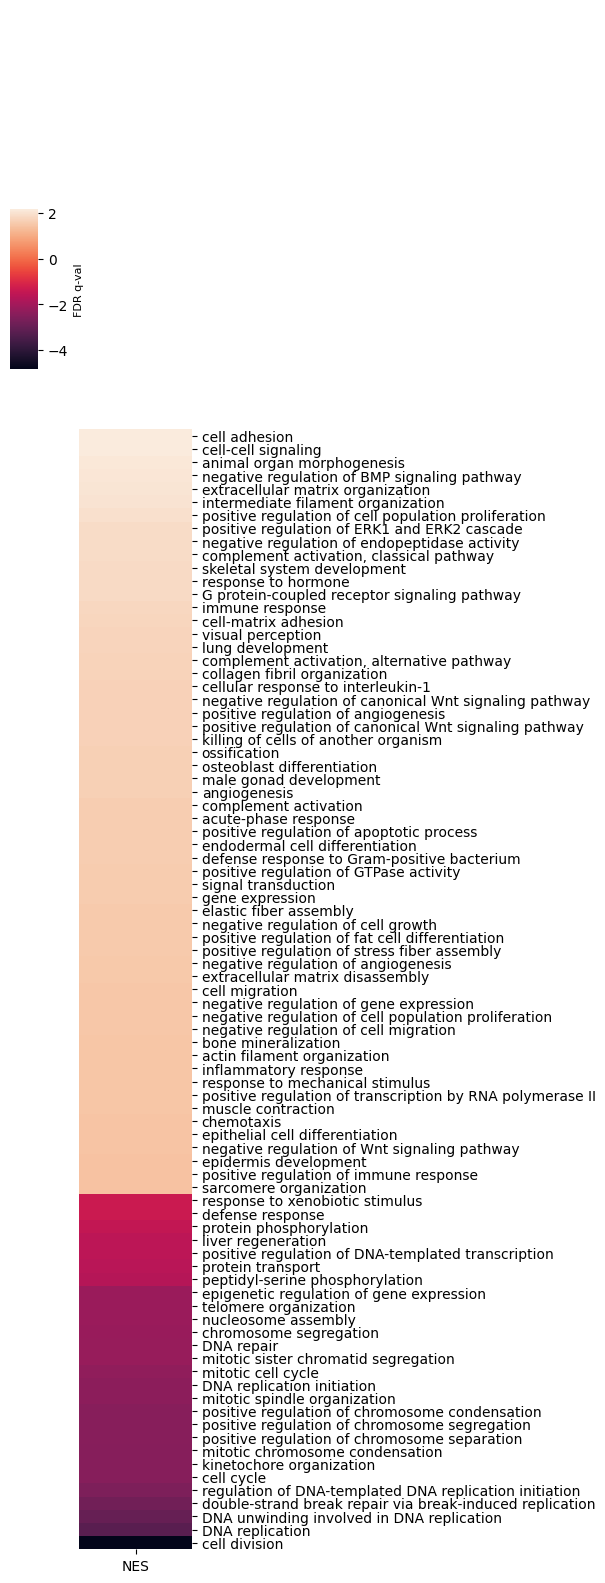

In [32]:
# Plot enriched sets
go_table_annotated['NES'] = pd.to_numeric(go_table_annotated['NES'], errors='coerce')
go_table_annotated.sort_values('NES', inplace=True, ascending=False)
cg = sns.clustermap(go_table_annotated.loc[go_table_annotated['FDR q-val'] < 0.25, ['NES']],
                    yticklabels=go_table_annotated.loc[go_table_annotated['FDR q-val'] < 0.25, 'Description'],
                    linewidths=0, figsize=(2, 20),
                    col_cluster=False, row_cluster=False,
                    cbar_kws={'label': 'FDR q-val', 'orientation': 'vertical'})
cg.cax.set_position([-0.01, 0.7, cg.ax_row_dendrogram.get_position().width, 0.08])
cg.cax.yaxis.label.set_size(8)

**!!! Exercise !!!**

1- Repeat GSEA using "MF" or "CC" GO ontologies

-> for gene, terms in ns2assoc['MM'].items():

-> for gene, terms in ns2assoc['CC'].items():